In [1]:
#Load in necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFECV
from sklearn import linear_model
import scipy.stats as stats

In [2]:
#Load in data
df = pd.read_csv('baseballdatabank-master/core/Teams.csv')

# EDA

In [3]:
df

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,24,0.834,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,16,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,15,0.818,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,8,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,14,0.840,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,2019,NL,SLN,STL,C,1,162,81.0,91,71,...,168,0.989,St. Louis Cardinals,Busch Stadium III,3480393.0,98,97,STL,SLN,SLN
2921,2019,AL,TBA,TBD,E,2,162,81.0,96,66,...,126,0.985,Tampa Bay Rays,Tropicana Field,1178735.0,97,96,TBR,TBA,TBA
2922,2019,AL,TEX,TEX,W,3,162,81.0,78,84,...,143,0.982,Texas Rangers,Globe Life Park in Arlington,2132994.0,111,112,TEX,TEX,TEX
2923,2019,AL,TOR,TOR,E,4,162,81.0,67,95,...,141,0.984,Toronto Blue Jays,Rogers Centre,1750114.0,97,98,TOR,TOR,TOR


In [4]:
#Only include data after 1990 and remove strike years, then reset indices
df = df[df.yearID>1990]
df = df[(df.yearID != 1994) & (df.yearID != 1995)]
df.reset_index(inplace = True, drop = True)

In [5]:
df.isna().sum()

yearID             0
lgID               0
teamID             0
franchID           0
divID              0
Rank               0
G                  0
Ghome              0
W                  0
L                  0
DivWin             0
WCWin             80
LgWin              0
WSWin              0
R                  0
AB                 0
H                  0
2B                 0
3B                 0
HR                 0
BB                 0
SO                 0
SB                 0
CS                 0
HBP                0
SF                 0
RA                 0
ER                 0
ERA                0
CG                 0
SHO                0
SV                 0
IPouts             0
HA                 0
HRA                0
BBA                0
SOA                0
E                  0
DP                 0
FP                 0
name               0
park               0
attendance         0
BPF                0
PPF                0
teamIDBR           0
teamIDlahman45     0
teamIDretro  

Text(0.5, 0, 'Wins')

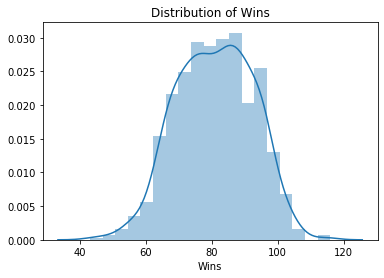

In [6]:
#plot distribution of wins (Our target variable)
sns.distplot(df['W'])
plt.title('Distribution of Wins')
plt.xlabel('Wins')

In [7]:
df['W'].describe()


count    796.00000
mean      80.96608
std       11.61262
min       43.00000
25%       72.00000
50%       81.00000
75%       90.00000
max      116.00000
Name: W, dtype: float64

In [8]:
df.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')

count     796.000000
mean      745.170854
std        86.344540
min       513.000000
25%       685.000000
50%       740.000000
75%       801.000000
max      1009.000000
Name: R, dtype: float64


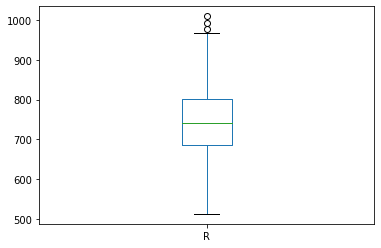

In [9]:
#describe and view box plot on runs
print(df.R.describe())
df.R.plot(kind = 'box')

In [10]:
#engineer some potentially useful features
df['run_diff'] = df['R'] - df['RA']
df['avg'] = df['H']/df['AB']
df['OBP'] = (df['H']+df['BB']+df['HBP'])/(df['AB']+df['BB']+df['HBP']+df['SF'])
df['1B'] = df['H']-df['HR']-df['3B']-df['2B']
df['SLG'] = (df['1B']+2*df['2B']+3*df['3B']+4*df['HR'])/df['AB']
df['OPS'] = df['OBP'] + df['SLG']
df['FIP'] = (13*df.HRA + 3* df.BBA - 2 * df.SOA)/(df.IPouts/3)

In [11]:
#create list of features to include in our model and create a dataframe of them
features = ['R','H','2B','3B','HR','BB','SO','SB','CS','HBP','SF','RA','ER','ERA','CG','SHO','HA','HRA','BBA','SOA','E','DP','FP','run_diff', 'avg','OBP','1B','SLG','OPS','FIP']
df_features = df[features]
df_target = df['W']


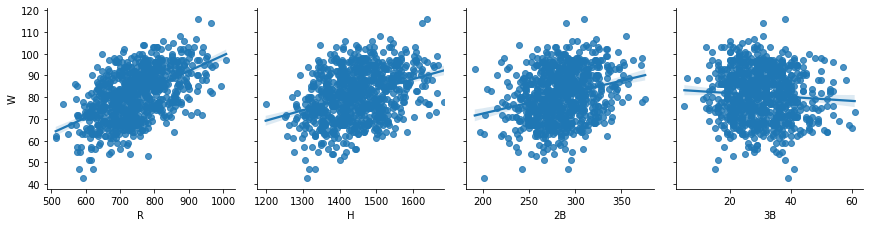

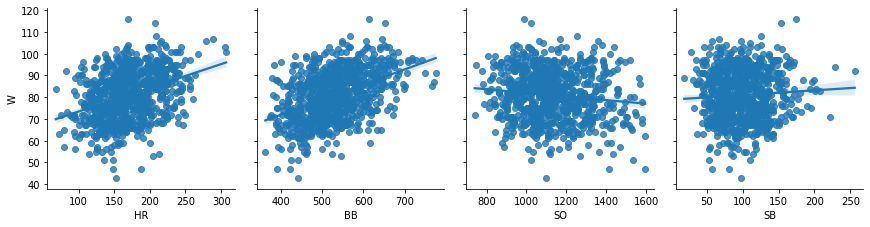

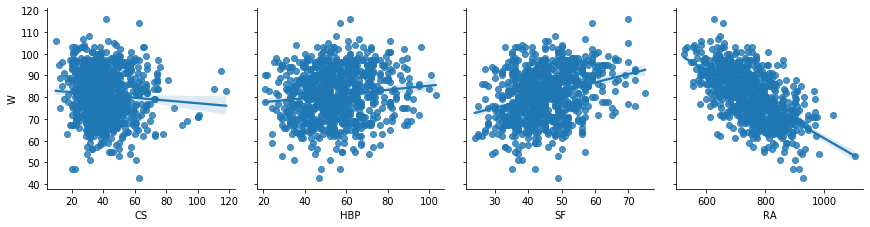

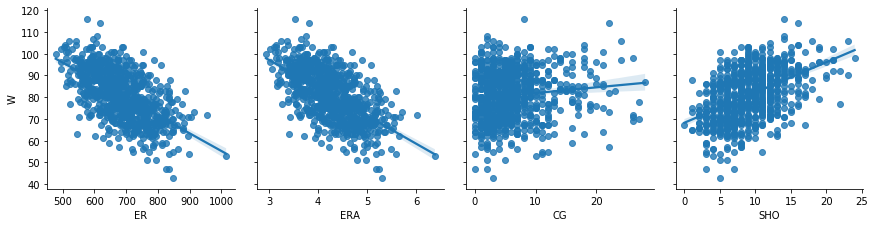

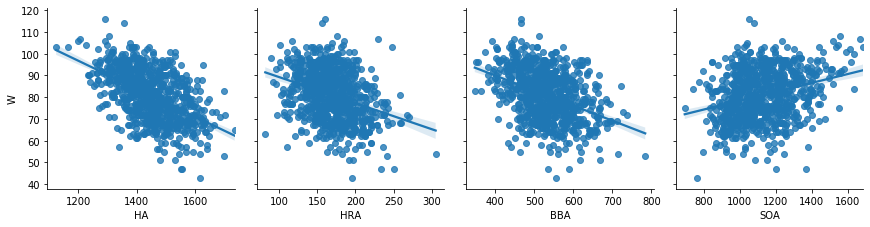

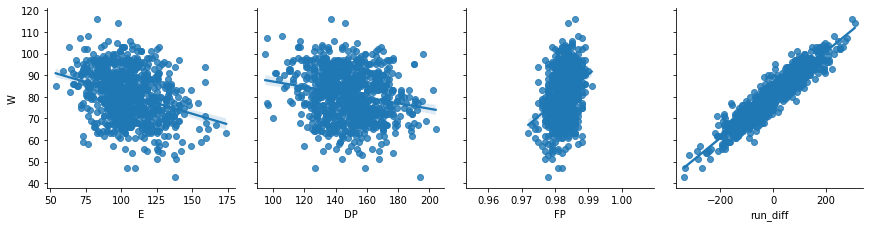

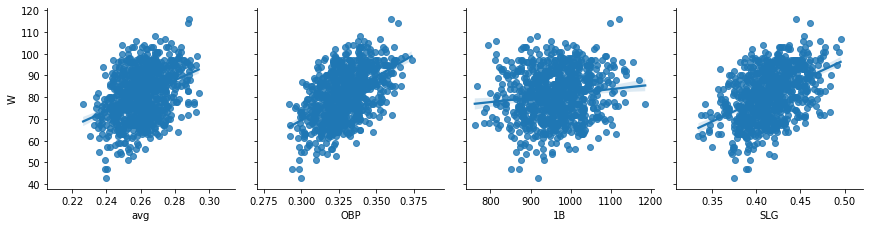

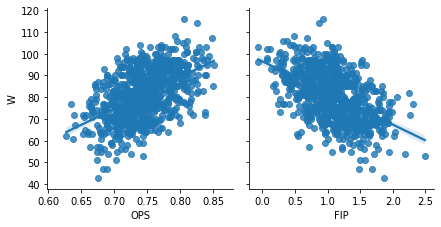

In [12]:
#plot all our features against Wins
n = 4
row_groups= [features[i:i+n] for i in range(0, len(features), n) ]
for i in row_groups:
    pp = sns.pairplot(data=df, y_vars=['W'],x_vars=i, kind="reg", height=3)

Text(27.125, 0.5, 'Wins')

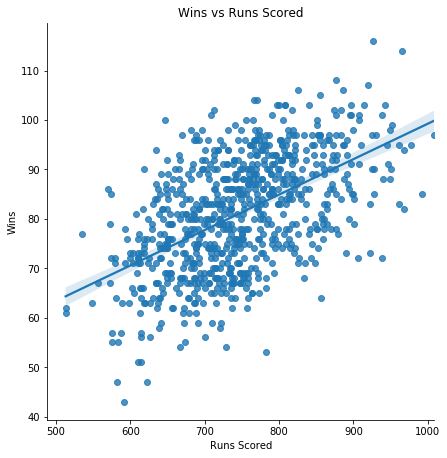

In [13]:
#plot wins versus Runs Scored
sns.pairplot(data = df, y_vars = 'W', x_vars = 'R', kind = 'reg',height = 6 )
plt.title('Wins vs Runs Scored')
plt.xlabel('Runs Scored')
plt.ylabel('Wins')

Text(27.125, 0.5, 'Wins')

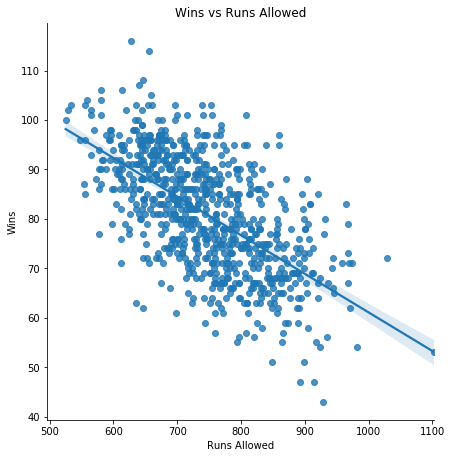

In [14]:
#Plot wins versus runs allowed
sns.pairplot(data = df, y_vars = 'W', x_vars = 'RA', kind = 'reg',height = 6 )
plt.title('Wins vs Runs Allowed')
plt.xlabel('Runs Allowed')
plt.ylabel('Wins')

# Create a Model

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df_features.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_features.columns)
lm = LinearRegression()
lm = lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
print('Train r squared: ',metrics.r2_score(y_train,y_train_pred))
y_pred = lm.predict(X_test)
print('Test r squared: ',metrics.r2_score(y_test,y_pred))

Train r squared:  0.9108007738605013
Test r squared:  0.8944924775611538


In [16]:
pd.DataFrame(zip(X_train.columns,lm.coef_)).sort_values(by = 1)

,0,1
28,OPS,-2.800687e+14
1,H,-2.185929e+13
0,R,-7.735277e+12
13,ERA,-5.172257e+01
17,HRA,-2.440086e+01
18,BBA,-1.186013e+01
5,BB,-4.960735e+00
20,E,-1.264224e+00
9,HBP,-1.083015e+00
22,FP,-6.300076e-01


In [17]:
f = "W~R+H+HR+BB+SO+SB+CS+HBP+SF+RA+ER+ERA+CG+SHO+HA+HRA+BBA+SOA+E+DP+FP+run_diff+avg+OBP+SLG+OPS+FIP"
mlr_model = ols(formula=f, data=df).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     306.7
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        00:56:18   Log-Likelihood:                -2128.0
No. Observations:                 796   AIC:                             4308.
Df Residuals:                     770   BIC:                             4430.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    611.3588    358.151      1.707      0.088     -91.710    1314.428
R              0.0443      0.006      7.240      0.000       0.032       0.056
H             -0.1597      0.025     -6.294      0.000      -0.210      -0.110
HR             0.0592      0.014      4.115      0.000       0.031       0.087
BB            -0.0591      0.051     -1.159      0.247      -0.159       0.041
SO          6.133e-05      0.001      0.043      0.966      -0.003       0.003
SB             0.0069      0.005      1.293      0.197      -0.004       0.017
CS            -0.0444      0.015     -2.911      0.004      -0.074      -0.014
HBP           -0.0536      0.052     -1.038      0.300      -0.155       0.048
SF            -0.0162      0.032     -0.508      0.612      -0.079       0.046
RA            -0.0012      0.010     -0.127      0.899      -0.020       0.018
ER             0.5449      0.085      6.394      0.000       0.378       0.712
ERA          -90.2950     13.369     -6.754      0.000    -116.540     -64.050
CG            -0.0426      0.034     -1.268      0.205      -0.109       0.023
SHO            0.1960      0.047      4.214      0.000       0.105       0.287
HA            -0.0019      0.004     -0.454      0.650      -0.010       0.006
HRA           -0.5598      0.392     -1.427      0.154      -1.330       0.210
BBA           -0.1324      0.091     -1.461      0.144      -0.310       0.045
SOA            0.0825      0.060      1.370      0.171      -0.036       0.201
E             -0.1229      0.058     -2.113      0.035      -0.237      -0.009
DP            -0.0107      0.009     -1.193      0.233      -0.028       0.007
FP          -614.3154    357.555     -1.718      0.086   -1316.214      87.583
run_diff       0.0456      0.005      8.845      0.000       0.035       0.056
avg          806.9865    541.555      1.490      0.137    -256.114    1870.087
OBP          341.6781    314.884      1.085      0.278    -276.454     959.810
SLG         -209.8902    159.962     -1.312      0.190    -523.904     104.124
OPS          131.7879    156.116      0.844      0.399    -174.675     438.251
FIP           60.1137     43.647      1.377      0.169     -25.567     145.794
==============================================================================
Omnibus:                        1.653   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.437   Jarque-Bera (JB):                1.594
Skew:                          -0.011   Prob(JB):                        0.451
Kurtosis:                       3.218   Cond. No.                     1.00e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.12e-23. This might indic

In [18]:
#Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,R,H,2B,3B,HR,BB,SO,SB,CS,HBP,...,E,DP,FP,run_diff,avg,OBP,1B,SLG,OPS,FIP
R,NaN,0.776879,0.582234,0.002731,0.692865,0.621353,0.155955,0.005806,0.090600,0.210691,...,0.069641,0.083183,0.070396,0.594269,0.770071,0.878322,0.303805,0.906183,0.954203,0.236763
H,NaN,NaN,0.602732,0.145074,0.294026,0.276670,0.466564,0.048462,0.040178,0.045518,...,0.018876,0.185323,0.031737,0.392101,0.983983,0.819719,0.763756,0.709257,0.795367,0.255232
2B,NaN,NaN,NaN,0.046400,0.318093,0.259392,0.080256,0.162794,0.243802,0.228114,...,0.126222,0.053438,0.125186,0.301953,0.576947,0.553081,0.126402,0.631806,0.643530,0.111181
3B,NaN,NaN,NaN,NaN,0.282758,0.123253,0.132245,0.231082,0.200671,0.108843,...,0.109244,0.021779,0.097945,0.042853,0.157949,0.029903,0.178530,0.019379,0.002544,0.056759
HR,NaN,NaN,NaN,NaN,NaN,0.386382,0.347401,0.273537,0.370869,0.330964,...,0.189965,0.026707,0.171447,0.389732,0.258873,0.417098,0.296337,0.850853,0.746405,0.137721
BB,NaN,NaN,NaN,NaN,NaN,NaN,0.070784,0.044002,0.006204,0.026883,...,0.013278,0.016253,0.022761,0.482093,0.299802,0.745704,0.025901,0.438076,0.579092,0.052750
SO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.235241,0.410692,0.222016,...,0.204573,0.187617,0.167398,0.125368,0.522248,0.375626,0.698738,0.014431,0.127744,0.134079
SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.677907,0.129999,...,0.172392,0.029540,0.161743,0.038427,0.088648,0.073174,0.245632,0.159514,0.084399,0.045675
CS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.215960,...,0.354363,0.095914,0.325040,0.080652,0.104062,0.053255,0.326935,0.237143,0.145845,0.114931
HBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.108876,0.056866,0.091166,0.123950,0.035934,0.149231,0.208275,0.284619,0.253241,0.046271


In [19]:
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)
to_drop

['ER', 'ERA', 'FP', 'avg', 'SLG', 'OPS']

In [20]:
#Create new model after dropping columns
lm = lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
print('Train r squared: ',metrics.r2_score(y_train,y_train_pred))
y_pred = lm.predict(X_test)
print('Test r squared: ',metrics.r2_score(y_test,y_pred))

Train r squared:  0.9054716384696089
Test r squared:  0.8874858693309532


In [21]:
pd.DataFrame(zip(X_train.columns,lm.coef_)).sort_values(by = 1)

,0,1
23,FIP,-78.894117
17,SOA,-45.601698
5,BB,-7.373880
1,H,-4.130605
22,1B,-3.381959
11,RA,-1.873698
2,2B,-1.816107
9,HBP,-1.525763
4,HR,-1.237695
3,3B,-0.874682


In [22]:
f = "W~R+H+HR+BB+SO+SB+CS+HBP+SF+RA+CG+SHO+HA+HRA+BBA+SOA+E+DP+run_diff+OBP+FIP"
mlr_model = ols(formula=f, data=df).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     356.4
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        00:56:19   Log-Likelihood:                -2156.7
No. Observations:                 796   AIC:                             4355.
Df Residuals:                     775   BIC:                             4454.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5067     10.776     -0.047      0.963     -21.660      20.647
R              0.0327      0.004      7.507      0.000       0.024       0.041
H             -0.0903      0.011     -8.408      0.000      -0.111      -0.069
HR             0.0241      0.007      3.265      0.001       0.010       0.039
BB            -0.0870      0.010     -8.423      0.000      -0.107      -0.067
SO            -0.0014      0.001     -0.933      0.351      -0.004       0.001
SB             0.0044      0.005      0.811      0.418      -0.006       0.015
CS            -0.0149      0.015     -0.998      0.319      -0.044       0.014
HBP           -0.0794      0.014     -5.691      0.000      -0.107      -0.052
SF             0.0140      0.019      0.733      0.464      -0.024       0.052
RA            -0.0200      0.004     -4.523      0.000      -0.029      -0.011
CG            -0.0589      0.035     -1.702      0.089      -0.127       0.009
SHO            0.2267      0.048      4.749      0.000       0.133       0.320
HA             0.0020      0.004      0.501      0.616      -0.006       0.010
HRA            1.7461      0.190      9.194      0.000       1.373       2.119
BBA            0.4007      0.044      9.189      0.000       0.315       0.486
SOA           -0.2698      0.030     -9.144      0.000      -0.328      -0.212
E             -0.0113      0.009     -1.275      0.203      -0.029       0.006
DP            -0.0133      0.009     -1.507      0.132      -0.031       0.004
run_diff       0.0527      0.003     18.852      0.000       0.047       0.058
OBP          770.7719     85.341      9.032      0.000     603.245     938.299
FIP         -196.1901     21.179     -9.264      0.000    -237.764    -154.616
==============================================================================
Omnibus:                        1.332   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                1.192
Skew:                           0.046   Prob(JB):                        0.551
Kurtosis:                       3.166   Cond. No.                     1.04e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.28e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
#Removed features with high p values above .1
f = "W~R+H+HR+BB+HBP+RA+CG+SHO+HRA+BBA+SOA+run_diff+OBP+FIP"
mlr_model = ols(formula=f, data=df).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     547.5
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        00:56:19   Log-Likelihood:                -2160.4
No. Observations:                 796   AIC:                             4349.
Df Residuals:                     782   BIC:                             4414.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9147      8.866     -0.329      0.742     -20.320      14.490
R              0.0332      0.004      8.528      0.000       0.026       0.041
H             -0.0865      0.010     -8.805      0.000      -0.106      -0.067
HR             0.0207      0.007      3.098      0.002       0.008       0.034
BB            -0.0847      0.009     -9.209      0.000      -0.103      -0.067
HBP           -0.0801      0.013     -6.176      0.000      -0.106      -0.055
RA            -0.0200      0.003     -6.458      0.000      -0.026      -0.014
CG            -0.0615      0.032     -1.937      0.053      -0.124       0.001
SHO            0.2297      0.047      4.878      0.000       0.137       0.322
HRA            1.7259      0.177      9.777      0.000       1.379       2.072
BBA            0.3942      0.041      9.707      0.000       0.314       0.474
SOA           -0.2663      0.027     -9.809      0.000      -0.320      -0.213
run_diff       0.0532      0.002     25.250      0.000       0.049       0.057
OBP          755.0811     75.868      9.953      0.000     606.152     904.011
FIP         -193.6719     19.642     -9.860      0.000    -232.229    -155.115
==============================================================================
Omnibus:                        1.249   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.536   Jarque-Bera (JB):                1.116
Skew:                           0.033   Prob(JB):                        0.572
Kurtosis:                       3.171   Cond. No.                     1.17e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.97e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
#Try Lasso Model to see if it performs any better
lasso = Lasso(alpha=.02, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_r2 = metrics.r2_score(y_train, y_train_pred)
test_r2 = metrics.r2_score(y_test, y_pred)
print('Training Error: '+ str(train_r2) )
print('Testing Error: '+ str(test_r2) )

Training Error: 0.8942242857242884
Testing Error: 0.8766487124356288


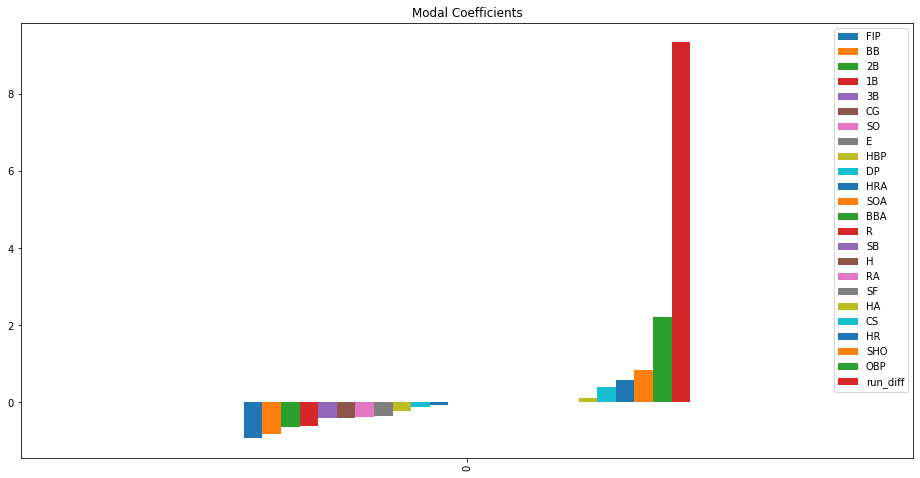

In [25]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=True, figsize=(16,8))

In [26]:
lasso_coef01.T

,0
FIP,-0.916351
BB,-0.808740
2B,-0.639585
1B,-0.619819
3B,-0.410297
CG,-0.397951
SO,-0.371028
E,-0.354575
HBP,-0.228021
DP,-0.116331


In [27]:
#Create model with RFE
ols_1 = linear_model.LinearRegression()
# Create recursive feature eliminator that scores features by r squared
selector = RFECV(estimator=ols_1, step=1, cv=5, scoring='r2')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)


RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

In [28]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [29]:
list(removed_rfe)

['SO', 'SB', 'CS', 'SF', 'CG', 'HA', 'E', 'DP']

In [30]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_r2 = np.sqrt(metrics.r2_score(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_r2)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_r2 = metrics.r2_score(y_test, y_pred_rfe)

print('Testing Root Mean Squared Error:' , testRFE_r2)


print('Original: ', test_r2, "vs. RFE: ", testRFE_r2)

Training Root Mean Squared Error: 0.950305229603412
Testing Root Mean Squared Error: 0.8906001371426926
Original:  0.8766487124356288 vs. RFE:  0.8906001371426926
